<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter17/Image-Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-guided image-inpainting

The [StableDiffusionInpaintPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/inpaint#diffusers.StableDiffusionInpaintPipeline) allows you to edit specific parts of an image by providing a mask and a text prompt. It uses a version of Stable Diffusion, like [`runwayml/stable-diffusion-inpainting`](https://huggingface.co/runwayml/stable-diffusion-inpainting) specifically trained for inpainting tasks.

Get started by loading an instance of the [StableDiffusionInpaintPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/inpaint#diffusers.StableDiffusionInpaintPipeline):

In [ ]:
%%capture
%pip install diffusers transformers accelerate


In [ ]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline

pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
)
pipeline = pipeline.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Download an image and a mask of a dog which you'll eventually replace:

In [ ]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

Now you can create a prompt to replace the mask with something else:

In [ ]:
prompt = "Face of a white cat, high resolution, sitting on a park bench"
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

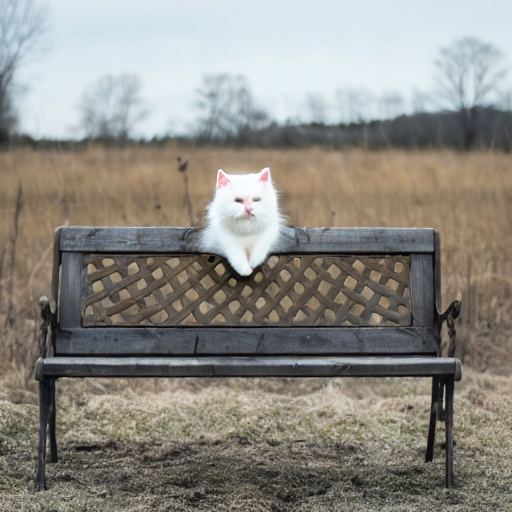

In [ ]:
image

`image`          | `mask_image` | `prompt` | output |
:-------------------------:|:-------------------------:|:-------------------------:|-------------------------:|
<img src="https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png" alt="drawing" width="250"/> | <img src="https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png" alt="drawing" width="250"/> | ***Face of a yellow cat, high resolution, sitting on a park bench*** | <img src="https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/in_paint/yellow_cat_sitting_on_a_park_bench.png" alt="drawing" width="250"/> |


<Tip warning={true}>

A previous experimental implementation of inpainting used a different, lower-quality process. To ensure backwards compatibility, loading a pretrained pipeline that doesn't contain the new model will still apply the old inpainting method.

</Tip>

Check out the Spaces below to try out image inpainting yourself!

<iframe
	src="https://runwayml-stable-diffusion-inpainting.hf.space"
	frameborder="0"
	width="850"
	height="500"
></iframe>

# Explanation


This is our entrypoint (Run `pipeline.__call__??`)
```python
@torch.no_grad()
def __call__(
    self,
    prompt: Union[str, List[str]] = None,
    image: Union[torch.FloatTensor, PIL.Image.Image] = None,
    mask_image: Union[torch.FloatTensor, PIL.Image.Image] = None,
    guidance_scale: Optional[float] = 7.5,
    negative_prompt: Optional[Union[str, List[str]]] = None,
):
```

---

Start by invoking `self.check_inputs` and 
set the do_classifier_free_guidance flag, which is a technique for improving the relevance and quality of generated images. See classifier free guidance in controlnet section for the explanation
```python
self.check_inputs(prompt, strength, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds)
if prompt is not None and isinstance(prompt, str):
    batch_size = 1
do_classifier_free_guidance = guidance_scale > 1.0
```

---

Call the self.encode_prompt to encode the provided prompts (both positive and negative) and store the resulting embeddings in prompt_embeds and negative_prompt_embeds.
```python
prompt_embeds, negative_prompt_embeds = self.encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    do_classifier_free_guidance,
    negative_prompt,
)
if do_classifier_free_guidance:
	prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
```

---

Preprocess the mask and the input image. When you send the mask_image, as input to the function, it has white pixels in the region that needs inpainting and black in place where the image needs to remain unchanged. However during `preprocess_mask` the pixels are swapped
```python
image = preprocess_image(image, batch_size)
mask_image = preprocess_mask(mask_image, batch_size, self.vae_scale_factor)
```

---

Set the time steps and generate initial noisy latents (`latents`) for the original image that needs inpainting (`init_latents_orig`)
```python
self.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength, device)
latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)
latents, init_latents_orig, noise = self.prepare_latents(
	image, latent_timestep, num_images_per_prompt, prompt_embeds.dtype, device, generator
)
```

---

Start inpainting for as many timesteps as needed by doing the following
```python
for i, t in enumerate((progress_bar:=make_progress_bar(timesteps))):
```

---

First make copies of latents in case if classifier free guidance is needed
```python
	...
	latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
```

---

Predict the noise and guide the noise away from negative prompt if needed
```python
	...
	noise_pred = self.unet(
		latent_model_input,
		t,
		encoder_hidden_states=prompt_embeds,
		cross_attention_kwargs=cross_attention_kwargs,
		return_dict=False,
	)[0]
	# perform guidance
	if do_classifier_free_guidance:
		...
```

---

Add noise to the original image latents based on timestep. Let's call this `init_latents_proper`. As indicated by mask, take the background portion of `init_latents_proper` and paste it on top of `latents`. This way, we are considering the latents for only the parts that need changing and keeping the original latents for the background.
```python
	...
	latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
	init_latents_proper = self.scheduler.add_noise(init_latents_orig, noise, torch.tensor([t]))
	latents = (init_latents_proper * mask) + (latents * (1 - mask))
```

$$latents = (orig\_latents*mask)+(text\_based\_latents*(1-mask))$$
<img src='https://i.imgur.com/jZF1QDy.png' alt='image' height='400'>
